In [193]:
import pandas as pd
import os
import json
# !pip install pywer
import pywer
# !pip install pyjarowinkler
from pyjarowinkler import distance as jwdistance
from tqdm import tqdm

class Const:
    OCR = 'ocr'
    GROUND = 'groundtruth'
    REGION = 'region'
    LINE = 'line'
    SENTENCE = 'sentence'
    FILE = 'filename'
    DATASET = 'dataset_name'
    PREDICTION = 'prediction'
    PROMPT = 'prompt'
    LANGUAGE = 'language'
    NONE = None


### Lookup datasets

In [194]:
datasets = []

for root, dirs, files in os.walk('../data/datasets/ocr/converted'):
    for file in files:
        if file.endswith(".jsonl"):
            input_file = os.path.join(root, file)
            if 'sample' not in input_file:
                with open(input_file) as f:
                    lines = f.read().splitlines()
                df_inter = pd.DataFrame(lines)
                df_inter.columns = ['json_element']
                df_inter['json_element'].apply(json.loads)
                df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                dataset_name = root.split('/')[-1].replace('_', '-')
                print(input_file, dataset_name)
                df['dataset_name'] = [dataset_name] * len(df)
                if 'ajmc' in dataset_name:
                    df['language'] = ['el'] * len(df)
                if 'overproof' in dataset_name:
                    df['language'] = ['en'] * len(df)
                if 'impresso' in dataset_name:
                    df['language'] = ['de'] * len(df)
                    
                datasets.append(df)
            

../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed.jsonl ajmc-mixed
../data/datasets/ocr/converted/overproof/overproof.jsonl overproof
../data/datasets/ocr/converted/icdar-2019/icdar-2019.jsonl icdar-2019
../data/datasets/ocr/converted/icdar-2017/icdar-2017.jsonl icdar-2017
../data/datasets/ocr/converted/impresso/impresso-nzz.jsonl impresso
../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text.jsonl ajmc-primary


In [195]:
print('Number of unique lines/sentences/regions.\n')
for dataset in datasets:
    print('Dataset:', dataset['dataset_name'].unique()[0], len(dataset), 'with duplicates')
    print('No. lines:', dataset['ocr.line']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. sentences:', dataset['ocr.sentence']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. regions:', dataset['ocr.region']. nunique(), '/', len(dataset['ocr.region']))
    print('-'*80)

Number of unique lines/sentences/regions.

Dataset: ajmc-mixed 2131 with duplicates
No. lines: 870 / 2131 No. sentences: 679 / 2131 No. regions: 63 / 2131
--------------------------------------------------------------------------------
Dataset: overproof 2669 with duplicates
No. lines: 2278 / 2669 No. sentences: 399 / 2669 No. regions: 41 / 2669
--------------------------------------------------------------------------------
Dataset: icdar-2019 404 with duplicates
No. lines: 0 / 404 No. sentences: 404 / 404 No. regions: 41 / 404
--------------------------------------------------------------------------------
Dataset: icdar-2017 477 with duplicates
No. lines: 0 / 477 No. sentences: 461 / 477 No. regions: 28 / 477
--------------------------------------------------------------------------------
Dataset: impresso 1563 with duplicates
No. lines: 1256 / 1563 No. sentences: 577 / 1563 No. regions: 203 / 1563
--------------------------------------------------------------------------------
Data

In [196]:
# GENERATE_SAMPLE = False

# if GENERATE_SAMPLE:
#     from sklearn.model_selection import train_test_split

#     files_keep, files_removed, _, _ = train_test_split(dataset, dataset['dataset_name'], 
#                                                        test_size=0.90, random_state=42)
    
# if GENERATE_SAMPLE:
#     output_file = '../data/datasets/ocr/converted/sample/sample.jsonl'
#     with open(output_file, "w") as outfile:
#         for index, row in files_keep.iterrows():

#             json_line = json.dumps({Const.LANGUAGE: row['language'],
#                                     Const.FILE: row['filename'],
#                                     Const.DATASET: row['dataset_name'],
#                                     Const.OCR: {Const.LINE: row['ocr.line'],
#                                                 Const.SENTENCE: row['ocr.sentence'],
#                                                 Const.REGION: row['ocr.region']}, 
#                                     Const.GROUND: {Const.LINE: row['groundtruth.line'],
#                                                    Const.SENTENCE: row['groundtruth.sentence'],
#                                                    Const.REGION: row['groundtruth.region']},
#                                     'File': row['File'], 
#                                     'Date': row['Date'],
#                                     'Type': row['Type'], 
#                                     'NbAlignedChar': row['NbAlignedChar'], 
#                                     'article_id': row['article_id']
#                                     })

#             outfile.write(json_line + "\n")
#             outfile.flush()
            
            


### Analsys of preliminary results

In [197]:
results = []

for root, dirs, files in os.walk('../data/output'):
    for file in files:
        if file.endswith(".jsonl"):
            input_file = os.path.join(root, file)
            
            if 'sample' not in input_file:
                prompt = root.split('/')[-2]
                with open(input_file) as f:
                    lines = f.read().splitlines()
                try:
                    df_inter = pd.DataFrame(lines)
                    df_inter.columns = ['json_element']

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    model_dataset_name = file[8:-6]
                    model_name = model_dataset_name.replace(root.split('/')[-1] + '-', '').strip()
                    
                    df_inter['json_element'].apply(json.loads)
                    df = pd.json_normalize(df_inter['json_element'].apply(json.loads))
                    
                    df['model'] = [model_name] * len(df)
                    
                    df['dataset_name'] = [dataset_name] * len(df)
                    df['prompt'] = [prompt] * len(df)
                    
                    print(root.split('/')[-1], dataset_name, model_name, prompt)
#                     print(model_name)
                    results.append(df)
                except:
                    print('We could not load {}'.format(file))
                    

overproof overproof gpt-4 prompt_basic_02
overproof overproof gpt-3.5-turbo prompt_basic_02
We could not load results-overproof-gpt2.jsonl
overproof overproof facebook-opt-350m prompt_basic_02
We could not load results-overproof-decapoda-research-llama-7b-hf.jsonl
overproof overproof bigscience-bloom-560m prompt_basic_02
htrec htrec bigscience-bloom-560m prompt_basic_02
htrec htrec facebook-opt-350m prompt_basic_02
We could not load results-htrec-gpt2.jsonl
htrec htrec decapoda-research-llama-7b-hf prompt_basic_02
ajmc_mixed ajmc-mixed decapoda-research-llama-7b-hf prompt_basic_02
ajmc_mixed ajmc-mixed bigscience-bloom-560m prompt_basic_02
ajmc_mixed ajmc-mixed facebook-opt-350m prompt_basic_02
ajmc_mixed ajmc-mixed gpt-4 prompt_basic_02
We could not load results-icdar-2019-gpt2.jsonl
icdar-2019 icdar-2019 bigscience-bloom-560m prompt_basic_02
icdar-2019 icdar-2019 decapoda-research-llama-7b-hf prompt_basic_02
icdar-2019 icdar-2019 facebook-opt-350m prompt_basic_02
icdar-2019 icdar-201

In [198]:
len(results)

97

In [199]:
results[0].head()

filename dataset_name   
0  ../../data/datasets/ocr/original/overproof/dat...    overproof  \
1  ../../data/datasets/ocr/original/overproof/dat...    overproof   
2  ../../data/datasets/ocr/original/overproof/dat...    overproof   
3  ../../data/datasets/ocr/original/overproof/dat...    overproof   
4  ../../data/datasets/ocr/original/overproof/dat...    overproof   

                                          article_id   
0  7 year 1922 type Article title http://chronicl...  \
1  7 year 1922 type Article title http://chronicl...   
2  7 year 1922 type Article title http://chronicl...   
3  7 year 1922 type Article title http://chronicl...   
4  7 year 1922 type Article title http://chronicl...   

                    ocr.line   
0                 RAIDERS IN  \
1                  FREDERICK   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                        ocr.sentence   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

                                          ocr.region   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

            groundtruth.line   
0                 RAIDERS IN  \
1                FREDER IC K   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                groundtruth.sentence   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                  groundtruth.region   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                   prediction.prompt   
0  Correct the spelling and grammar of the follow...  \
1  Correct the spelling and grammar of the follow...   
2  Correct the spelling and grammar of the follow...   
3  Correct the spelling and grammar of the follow...   
4  Correct the spelling and grammar of the follow...   

             prediction.line   
0               Raiders Inc.  \
1                  Frederick   
2                  Land Haul   
3                 Of $84,000   
4  Watchman Bound and Gagged   

                                 prediction.sentence   
0  Raiders in Frederick Land Haul of $84,000: Wat...  \
1  Raiders in Frederick Land Haul of $84,000: Wat...   
2  Raiders in Frederick Land Haul of $84,000: Wat...   
3  Raiders in Frederick Land Haul of $84,000: Wat...   
4  Raiders in Frederick Land Haul of $84,000: Wat...   

                                   prediction.region  model           prompt  
0  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02  
1  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02  
2  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02  
3  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02  
4  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02

In [200]:
data = pd.concat(results)
data.head()


filename dataset_name   
0  ../../data/datasets/ocr/original/overproof/dat...    overproof  \
1  ../../data/datasets/ocr/original/overproof/dat...    overproof   
2  ../../data/datasets/ocr/original/overproof/dat...    overproof   
3  ../../data/datasets/ocr/original/overproof/dat...    overproof   
4  ../../data/datasets/ocr/original/overproof/dat...    overproof   

                                          article_id   
0  7 year 1922 type Article title http://chronicl...  \
1  7 year 1922 type Article title http://chronicl...   
2  7 year 1922 type Article title http://chronicl...   
3  7 year 1922 type Article title http://chronicl...   
4  7 year 1922 type Article title http://chronicl...   

                    ocr.line   
0                 RAIDERS IN  \
1                  FREDERICK   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                        ocr.sentence   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

                                          ocr.region   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

            groundtruth.line   
0                 RAIDERS IN  \
1                FREDER IC K   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                groundtruth.sentence   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                  groundtruth.region   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                   prediction.prompt  ...   
0  Correct the spelling and grammar of the follow...  ...  \
1  Correct the spelling and grammar of the follow...  ...   
2  Correct the spelling and grammar of the follow...  ...   
3  Correct the spelling and grammar of the follow...  ...   
4  Correct the spelling and grammar of the follow...  ...   

                                 prediction.sentence   
0  Raiders in Frederick Land Haul of $84,000: Wat...  \
1  Raiders in Frederick Land Haul of $84,000: Wat...   
2  Raiders in Frederick Land Haul of $84,000: Wat...   
3  Raiders in Frederick Land Haul of $84,000: Wat...   
4  Raiders in Frederick Land Haul of $84,000: Wat...   

                                   prediction.region  model           prompt   
0  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02  \
1  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02   
2  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02   
3  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02   
4  Raiders in Frederick Land Haul of $84,000\n\nW...  gpt-4  prompt_basic_02   

  century language File Date Type NbAlignedChar  
0     NaN      NaN  NaN  NaN  NaN           NaN  
1     NaN      NaN  NaN  NaN  NaN           NaN  
2     NaN      NaN  NaN  NaN  NaN           NaN  
3     NaN      NaN  NaN  NaN  NaN           NaN  
4     NaN      NaN  NaN  NaN  NaN           NaN  

[5 rows x 21 columns]

## Post-process

In [201]:
import Levenshtein
from Levenshtein import distance

def compute_normalized_levenshtein_similarity(ocr_text, ground_truth_text):
    length = max(len(ocr_text), len(ground_truth_text))
    levenshtein_distance = distance(ocr_text, ground_truth_text)
    similarity = (length - levenshtein_distance) / length
    return similarity

def compute_jaccard(ocr_text, ground_truth_text):
    try: 
        return jwdistance.get_jaro_distance(ocr_text, ground_truth_text)
    except:
        return 0.0

# def get_improvement(original_distance, corrected_distance):
#     return 1.0 - (original_distance - corrected_distance)

def get_improvement(original_similarity, corrected_similarity):
    if corrected_similarity != 0:
        return (corrected_similarity - original_similarity) / corrected_similarity
    else:
        return corrected_similarity - original_similarity

In [202]:
data.tail()


filename       dataset_name article_id   
325  Wecklein1894  ajmc-primary-text        NaN  \
326  Wecklein1894  ajmc-primary-text        NaN   
327  Wecklein1894  ajmc-primary-text        NaN   
328  Wecklein1894  ajmc-primary-text        NaN   
329  Wecklein1894  ajmc-primary-text        NaN   

                                      ocr.line   
325  ὅπου δ’ ὑβρίζειν δρᾶν θ’ ἃ βούλεται παρῇ,  \
326         ταύτην νόμιζε τὴν πόλιν χρόνῳ ποτὲ   
327       ἐξ οὐρίων δραμοῦσαν ἐς βυθὸν πεσεῖν.   
328     ΧΟ. Μενέλαε, μὴ γνώμας ὑποστήσας σοφὰς   
329     ΧΟ. Μενέλαε, μὴ γνώμας ὑποστήσας σοφὰς   

                                          ocr.sentence   
325  δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...  \
326  δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...   
327  δέος γὰρ πρόσεστιν αἰσχύνη W ὁμοῦ, σωτηρίαν ἔχ...   
328                                                ΧΟ.   
329                                                ΧΟ.   

                                            ocr.region   
325  μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...  \
326  μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...   
327  μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...   
328  μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...   
329  μηδὲν φόβου πρόβλημα und αἰδοῦς ἔχων. ἀλλ’ ἄνδ...   

                              groundtruth.line   
325  ὅπου δ’ ὑβρίζειν δρᾶν θ’ ἃ βούλεται παρῇ,  \
326         ταύτην νόμιζε τὴν πόλιν χρόνῳ ποτὲ   
327       ἐξ οὐρίων δραμοῦσαν ἐς βυθὸν πεσεῖν.   
328     ΧΟ. Μενέλαε, un γνώμας ὑποστήσας σοφὰς   
329     ΧΟ. Μενέλαε, un γνώμας ὑποστήσας σοφὰς   

                                  groundtruth.sentence   
325  δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...  \
326  δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...   
327  δέος γὰρ ᾧ πρόσεστιν αἰσχύνη θ’ ὁμοῦ, σωτηρίαν...   
328                                                ΧΟ.   
329                                                ΧΟ.   

                                    groundtruth.region   
325  μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...  \
326  μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...   
327  μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...   
328  μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...   
329  μηδὲν φόβου πρόβλημα μηδ’ αἰδοῦς ἔχων. ἀλλ’ ἄν...   

                                     prediction.prompt  ...   
325  Correct the text: "δέος γὰρ πρόσεστιν αἰσχύνη ...  ...  \
326  Correct the text: "ταύτην νόμιζε τὴν πόλιν χρό...  ...   
327  Correct the text: "ἐξ οὐρίων δραμοῦσαν ἐς βυθὸ...  ...   
328  Correct the text: "ΧΟ. Μενέλαε, μὴ γνώμας ὑποσ...  ...   
329                                                NaN  ...   

                                   prediction.sentence   
325  There are no errors in this text. Here is the ...  \
326  There are no errors in this text. Here is the ...   
327  There are no errors in this text. Here is the ...   
328                                I'm sorry but "ΧΟ."   
329                                I'm sorry but "ΧΟ."   

                                     prediction.region          model   
325  No changes are needed as this appears to be a ...  gpt-3.5-turbo  \
326  No changes are needed as this appears to be a ...  gpt-3.5-turbo   
327  No changes are needed as this appears to be a ...  gpt-3.5-turbo   
328  No changes are needed as this appears to be a ...  gpt-3.5-turbo   
329  No changes are needed as this appears to be a ...  gpt-3.5-turbo   

              prompt century language File Date Type NbAlignedChar  
325  prompt_basic_01     NaN      NaN  NaN  NaN  NaN           NaN  
326  prompt_basic_01     NaN      NaN  NaN  NaN  NaN           NaN  
327  prompt_basic_01     NaN      NaN  NaN  NaN  NaN           NaN  
328  prompt_basic_01     NaN      NaN  NaN  NaN  NaN           NaN  
329  prompt_basic_01     NaN      NaN  NaN  NaN  NaN           NaN  

[5 rows x 21 columns]

In [203]:
gt_text = "149 Obrázek z maloměstského kukátka. Podává L. Gro"
ocr_text = "149 Obrázek z maloměstského kukátka. Podává L. Grw"
pred_text = """Correct the text: "149 Obrázek z maloměstského kukátka. Podává L. Grwsmannová-Brodská. Místo děje: salon paní stavitelky; doba: čas věnovaný kávové „visitě"; jednající osoby: dámy přednější honorace městské, z nichž •většina je mladá a některé skutečně hezké. Na stole prostřeném krásným ubrusem damaškovým stojí talíře s koláčky, věnečky a preclíčky, kol toho pěkně se vyjímají křišťálové sklenky s vodou, stříbrné lžičky a šálky z jemného porcelánu, jejichž vonný obsah na přítomné paničky zdá se velmi blaze působiti. Ze živějšího hovoru vyznívá právě hlas paní notářky, která ve spravedlivém rozhorlení mluví: „Ano, mé dámy, již jest to takové! Samy ráčily jste býti svědky, jak svorně i jednohlasně byl přijat návrh paní sládkové, abychom si pořídily kroje národní a tak přispěly ku zvýšení lesku slavnosti, již pořádá náš statečný studentský spolek „Hvězda", a když již nás páni akademikové poctili důvěrou, že v naše ruce složili starost o buffet a jiné ještě funkce, tož měly bychom snad též jiti za příkladem slečen berních a vzdáti se činnosti jen proto, že se zdá paní berní národní kroj pro tři dcery býti nějakou zby tečnou výlohou?" Paničky projevovaly svoji nevoli, každá jiným spůsobem. Mladá paní adjunktová v duchu si umiňovala, že ve svém přátel ství k berňovům trochu ochladne; to tak! aby ten jejich pošetilý nápad, úóinkovati při slavnosti v obyčejném oděvu, přece zvítězil a dámám se bylo odříci těch půvabných krojů venkovských, co by si jen ona, paní adjunktová, počala s tou haldou brokátu, atlasu, krajek, stuh a aksamitu, za což vydala nejednu desítku, utěšujíc se tím, jak jí to bude slušeti! Hm, a škodu z toho také míti nebude, muž se bude musit po několik měsíců uskrovnit, služka se má beztoho též až příliš dobře, uhradí se to na domácnosti a bude! Nyní ujala se slova paní doktorka: „Aj, od berních to není nic divného, považte jen: tolik dětí! Vždyť my všecky víme, že kdyby sobě slečny toillety samy ne řídily, mnohého by nemohly míti; ony pak mají zásadu: nemá-li být něco pěkné, tož raději nic!" „Pravda, ale slečny Elišky, té nejmladší, jest mně líto; těšila se velice na selský kroj." „Ba ano, byla by v něm vypadala roztomile." „Nyní má po radosti." „Inu, proč má tak nepřející matinku." „To není to, má drahá, jest v tom však jiný háček." „Ah, ano; vždyť víme, že sotva tak tak vyjdou." „Ale na knihy, které jsi tvá, jinak našel byste jen krytí těch mladých mozí, jinak je vydáte." „A tak bude, ostatně jdu až na knihy; ale slyšet jsem od někoho, že o krojech něco dělat, a že to bylo bude dělat národní, a když jsi tento národní učil jak, pak by měl nalézt tuto kartu, ta by se jistě mohla vyměnit se všemi. Můžete-li to od nás odkázat?" Všem ozdravila její hlas, když řekla: „Já, já! a já ho učím. S těmi páne akademiky jsem již mohla vyprávět o světě, v němž vznítí v některé nocy a jednoho dne vyrostá vám hrozný kouzelný strom zůstane, o němž je psáno: ‚Už jen žádat!" 50 V tuto chvíli koupili mohou-li všichni pánové i paní, že když jsi to čerpala, dá se jen kupit. Přižili to, a já jim vám koupi ukáži.
„A já už jste tím vyděštila. Pánové, děkuji vám za chytré vědomí, se kterým vám projeví, že se už točí dívčí zrcadlo." – 151"""
                
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))




-61.2692

In [204]:
def get_improvement(original_distance, corrected_distance):
    if corrected_distance != 0:
        return (corrected_distance - original_distance) / corrected_distance
    else:
        return corrected_distance - original_distance

In [205]:
gt_text = 'testing'
ocr_text = 'resting'
pred_text = 'testing'

compute_normalized_levenshtein_similarity(gt_text, ocr_text), distance(gt_text, ocr_text)

(0.8571428571428571, 1)

In [206]:
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))


0.1428571428571429

In [207]:
import Levenshtein

# Example strings
s1 = "testing"
s2 = "resting"

# Calculate the Levenshtein distance
lev_distance = Levenshtein.distance(s1, s2)
print(f"Levenshtein distance: {distance}")

# Calculate the Levenshtein similarity
similarity = (max(len(s1), len(s2)) - lev_distance) / max(len(s1), len(s2))
print(f"Levenshtein similarity: {similarity:.2f}")


Levenshtein distance: <function distance at 0x12bb93430>
Levenshtein similarity: 0.86


In [208]:
def postprocess(text):
    if text is not None:
        if len(text.strip()) > 0:
            if text.startswith('"'):
                text = text[1:]
            if text.endswith('"'):
                text = text[:-1]
    return text

In [210]:
data = pd.concat(results)

data['model'].unique()

array(['gpt-4', 'gpt-3.5-turbo', 'facebook-opt-350m',
       'bigscience-bloom-560m', 'decapoda-research-llama-7b-hf',
       'davinci', 'gpt2', 'tloen-alpaca-lora-7b'], dtype=object)

In [211]:
# Define OCR noise level bins
# bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
bins = [0, 0.7, 0.8, 0.9, 1]

# Assign OCR noise level labels
# labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]


for idx, result in tqdm(enumerate(results), total=len(results)):
    
    try:
        results[idx] = results[idx].fillna('No text')
    except:
        pass
#     results[idx] = results[idx][results[idx].model != 'tloen-alpaca-lora-7b']
    
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    
#     print('Dataset:', dataset_name, 'Model:', model_name, 'Prompt:', prompt)
    
    if 'alpaca' not in model_name:
    
        if 'icdar' in dataset_name:
            text_types = ['sentence', 'region']
        else:
            text_types = ['line', 'sentence', 'region']
        for segment_type in text_types:

            results[idx]['length'] = results[idx][f'groundtruth.{segment_type}'].str.len()
            results[idx] = results[idx][results[idx]['length'] > 3]

            results[idx][f'prediction.{segment_type}'] = results[idx][f'prediction.{segment_type}'].apply(postprocess)
            
#             # Compute Jaccard similarity
#             results[idx][f'{segment_type}-jaccard-ocr'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'ocr.{segment_type}']), axis=1)
            
#             results[idx][f'{segment_type}-jaccard-pred'] = \
#                 results[idx].apply(lambda x: compute_jaccard(x[f'groundtruth.{segment_type}'],
#                                                              x[f'prediction.{segment_type}']), axis=1)
            
            # Compute Lev similarity
            results[idx][f'{segment_type}-lev-ocr'] = \
                results[idx].apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'ocr.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-lev-pred'] = \
                results[idx].apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'prediction.{segment_type}']), axis=1)

            results[idx][f'{segment_type}-lev-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-lev-ocr'],
                                                             x[f'{segment_type}-lev-pred']), axis=1)
            # Compute CER
            results[idx][f'{segment_type}-cer-ocr'] = results[idx].apply(lambda x: pywer.cer(x[f'ocr.{segment_type}'], 
                                                                                             x[f'groundtruth.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-cer-pred'] = results[idx].apply(lambda x: pywer.cer(x[f'prediction.{segment_type}'], 
                                                                                              x[f'groundtruth.{segment_type}']), axis=1)

            # Compute WER
            results[idx][f'{segment_type}-wer-ocr'] = results[idx].apply(lambda x: pywer.wer(x[f'ocr.{segment_type}'], 
                                                                                             x[f'groundtruth.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-wer-pred'] = results[idx].apply(lambda x: pywer.wer(x[f'prediction.{segment_type}'], 
                                                         x[f'groundtruth.{segment_type}']), axis=1)

            # CER & WER improvement
            results[idx][f'{segment_type}-cer-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-cer-ocr'],
                                                             x[f'{segment_type}-cer-pred']), axis=1)
            results[idx][f'{segment_type}-wer-improvement'] = \
                results[idx].apply(lambda x: get_improvement(x[f'{segment_type}-wer-ocr'],
                                                             x[f'{segment_type}-wer-pred']), axis=1)

            # Create a new column for the OCR noise level bins
            results[idx][f"{segment_type}-ocr-noise-group"] = pd.cut(results[idx][f'{segment_type}-lev-ocr'], 
                                                     bins=bins, labels=labels, 
                                                     include_lowest=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [10:01<00:00,  6.20s/it]


In [ ]:
data = pd.concat(results)



In [213]:
data.iloc[7]



filename                    ../../data/datasets/ocr/original/overproof/dat...
dataset_name                                                        overproof
article_id                  7 year 1922 type Article title http://chronicl...
ocr.line                                      Travelling with a motor caravan
ocr.sentence                Travelling with a motor caravan and armed moto...
ocr.region                  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...
groundtruth.line                               Traveling with a motor caravan
groundtruth.sentence        Traveling with a motor caravan and armed motor...
groundtruth.region          RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...
prediction.prompt           Correct the spelling and grammar of the follow...
prediction.line                                Traveling with a motor caravan
prediction.sentence         Traveling with a motor caravan and armed motor...
prediction.region           Raiders in Frederick Land Haul of $8

In [214]:
data.columns

Index(['filename', 'dataset_name', 'article_id', 'ocr.line', 'ocr.sentence',
       'ocr.region', 'groundtruth.line', 'groundtruth.sentence',
       'groundtruth.region', 'prediction.prompt', 'prediction.line',
       'prediction.sentence', 'prediction.region', 'model', 'prompt', 'length',
       'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement', 'line-cer-ocr',
       'line-cer-pred', 'line-wer-ocr', 'line-wer-pred',
       'line-cer-improvement', 'line-wer-improvement', 'line-ocr-noise-group',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'sentence-cer-ocr', 'sentence-cer-pred', 'sentence-wer-ocr',
       'sentence-wer-pred', 'sentence-cer-improvement',
       'sentence-wer-improvement', 'sentence-ocr-noise-group',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'region-cer-ocr', 'region-cer-pred', 'region-wer-ocr',
       'region-wer-pred', 'region-cer-improvement', 'region-wer-improvement',
       'region-ocr-n

In [215]:
data['model'].unique()

array(['gpt-4', 'gpt-3.5-turbo', 'facebook-opt-350m',
       'bigscience-bloom-560m', 'decapoda-research-llama-7b-hf',
       'davinci', 'gpt2', 'tloen-alpaca-lora-7b'], dtype=object)

In [216]:
data['dataset_name'].unique()

array(['overproof', 'htrec', 'ajmc-mixed', 'icdar-2019', 'icdar-2017',
       'ajmc-primary-text', 'impresso-nzz'], dtype=object)

### Distribution of WER/CER rates for all datasets in the four quality bands, established via Levenshtein similarity.

In [217]:
data.dataset_name.unique()

array(['overproof', 'htrec', 'ajmc-mixed', 'icdar-2019', 'icdar-2017',
       'ajmc-primary-text', 'impresso-nzz'], dtype=object)

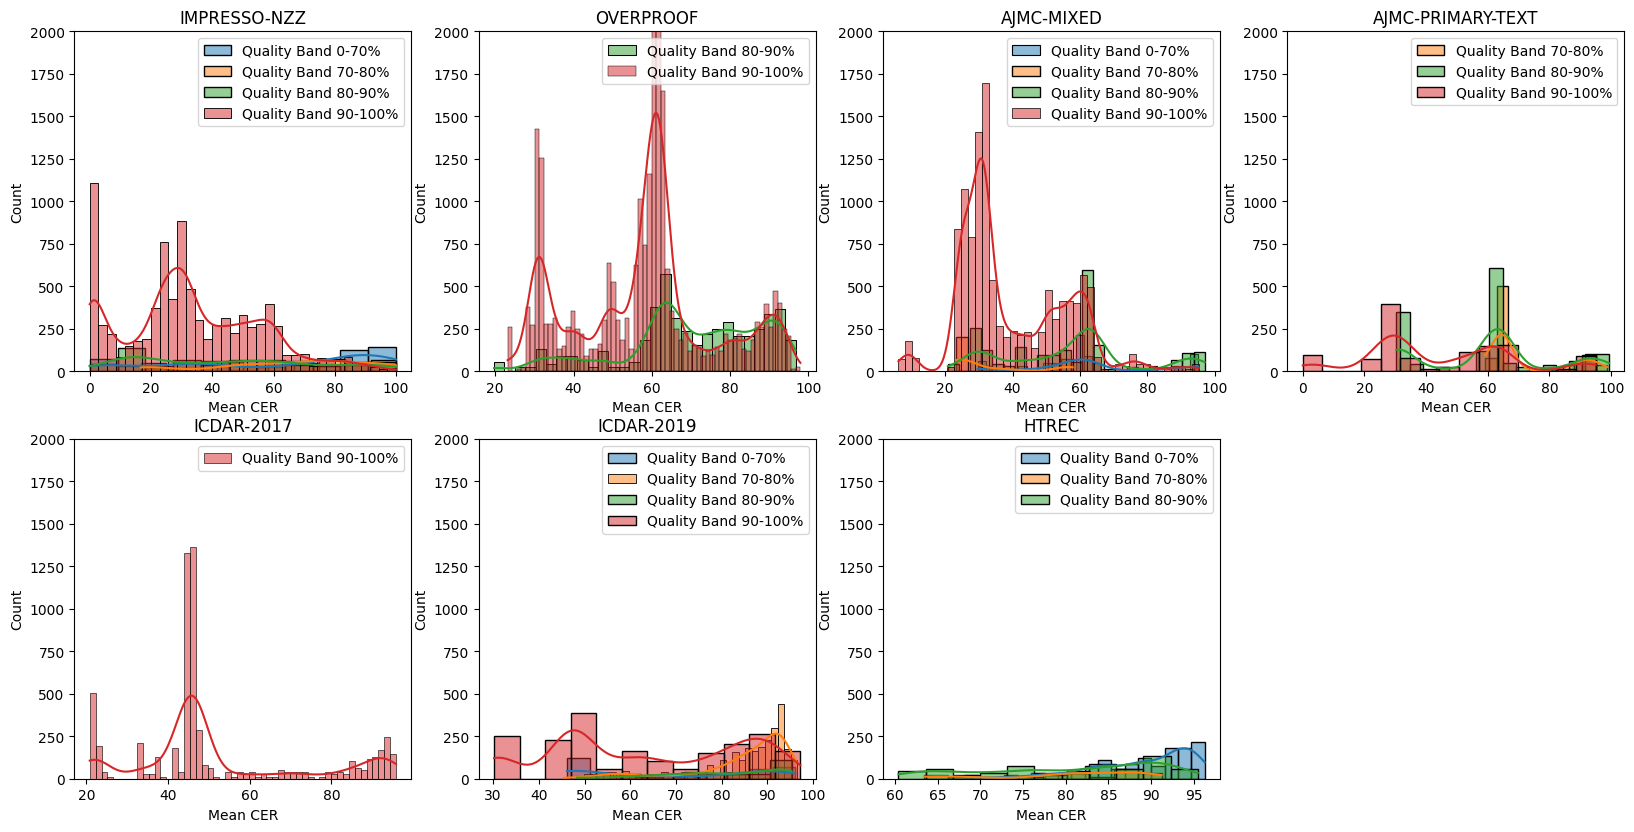

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

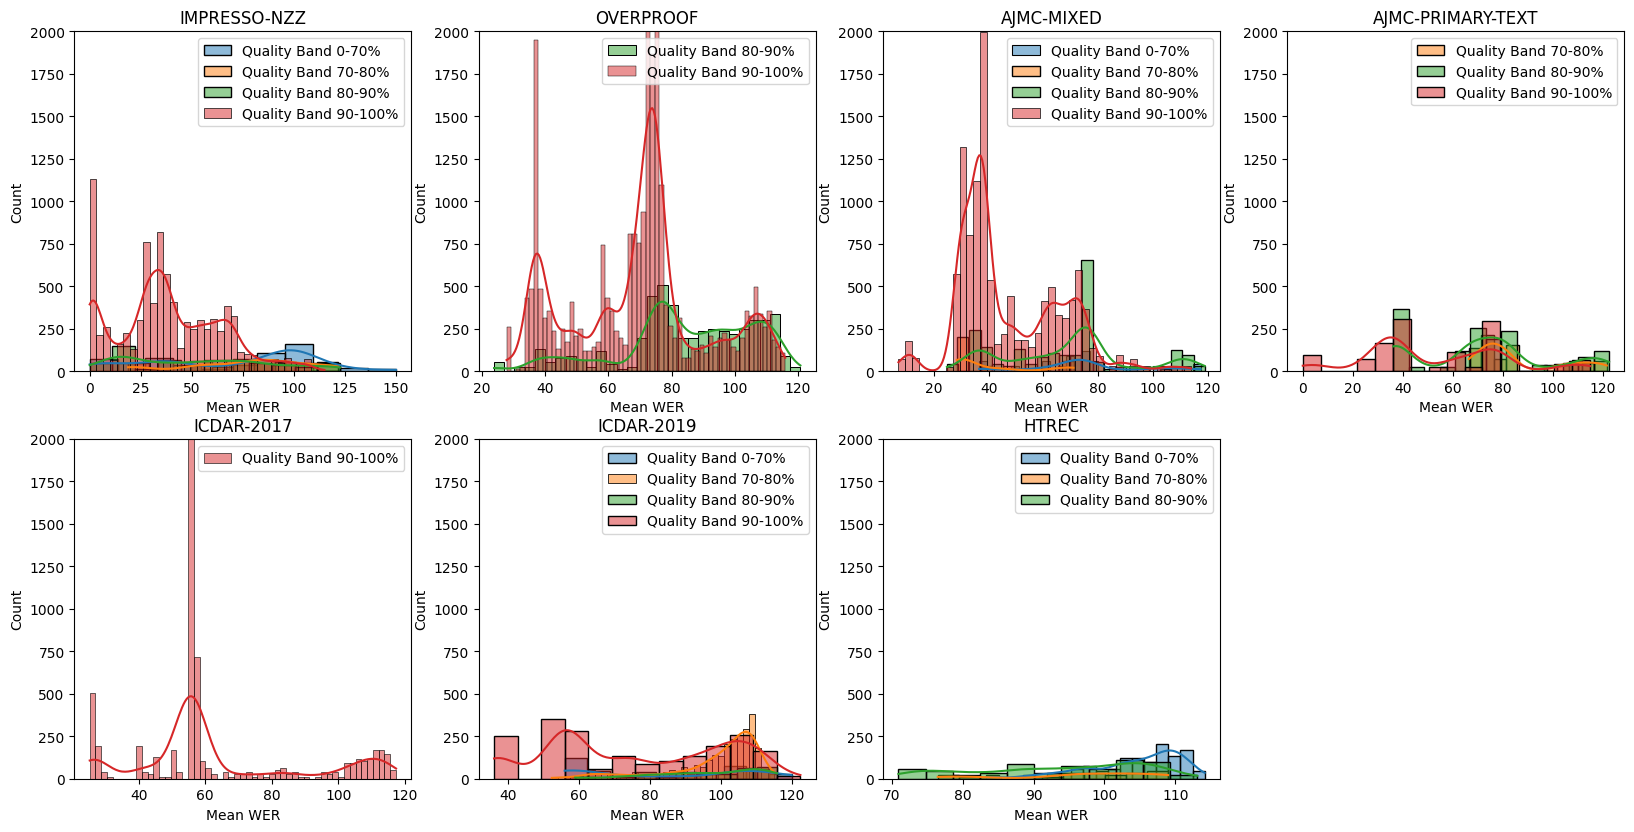

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the bins and labels for quality bands
bins = [0, 0.7, 0.8, 0.9, 1]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

for error_rate in ['cer', 'wer']:
    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]

        # Compute the mean WER across line, sentence, and region levels
        dataset_data[f'Mean {error_rate.upper()}'] = dataset_data[[f'line-{error_rate}-ocr', 
                                                 f'sentence-{error_rate}-ocr', 
                                                 f'region-{error_rate}-ocr']].mean(axis=1)

        plt.figure(figsize=(10, 6))
        # Plot the distribution of WERs for each quality band
        for band in labels:
            band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

            _ = sns.histplot(band_df, x=f"Mean {error_rate.upper()}", 
                             label=f"Quality Band {band}", kde=True, ax=axs[i])

        axs[i].set_ylim([0, 2000])
        axs[i].set_title(f'{dataset.upper()}')
        axs[i].legend()

    # Remove empty subplots
    for i in range(len(data.dataset_name.unique()), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.suptitle('Mean Word Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
    plt.show()

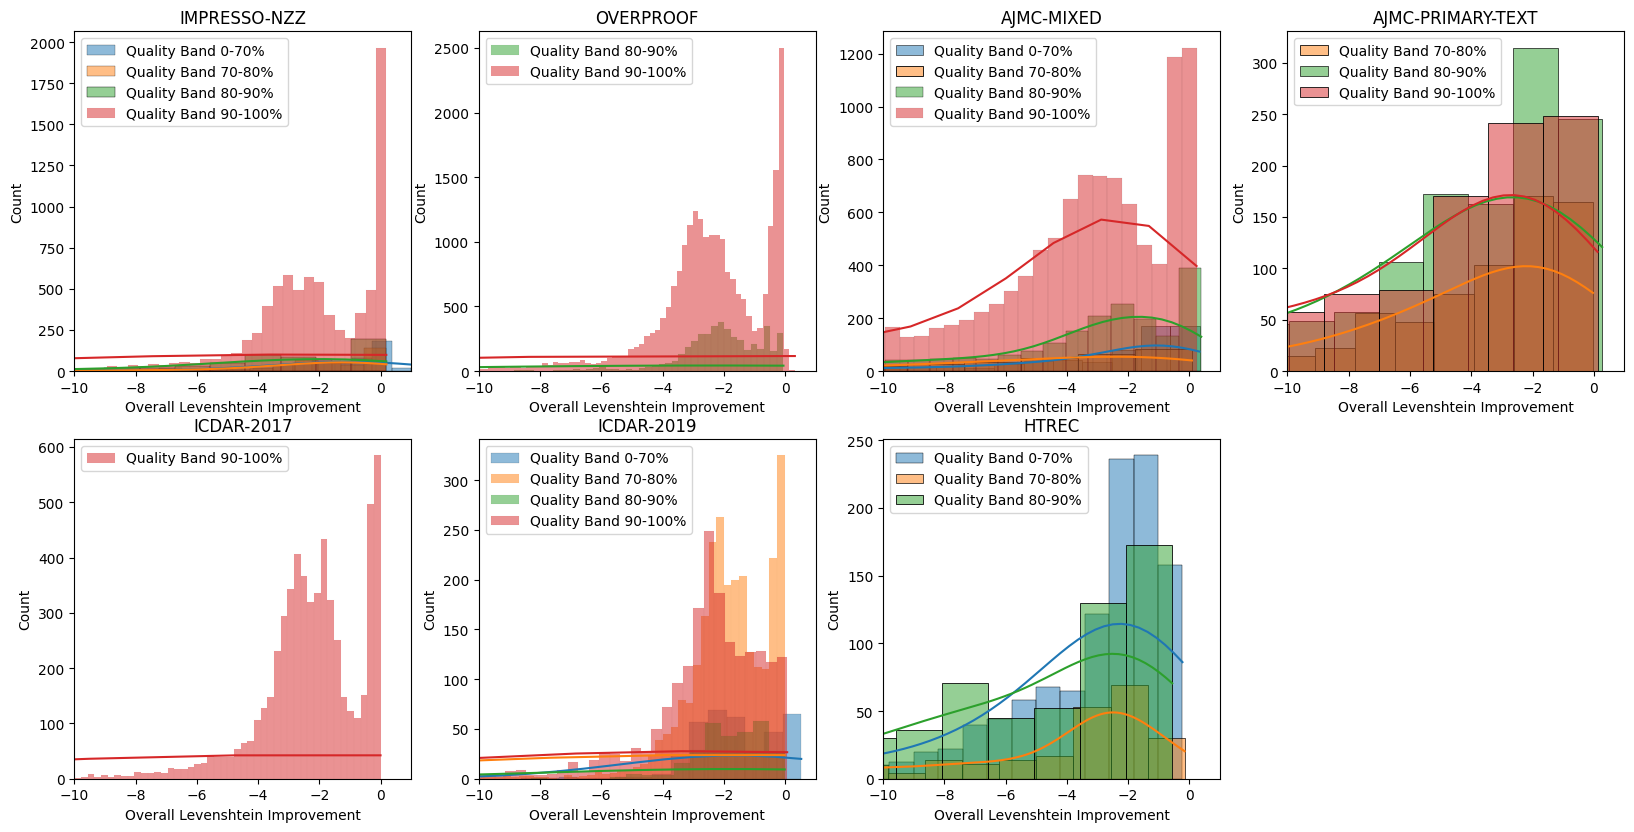

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the bins and labels for quality bands
bins = [0, 0.7, 0.8, 0.9, 1]
labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[data.dataset_name == dataset]

        # Compute the mean WER across line, sentence, and region levels
        dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
                                                          f'sentence-{error_rate}-improvement', 
                                                          f'region-{error_rate}-improvement']].mean(axis=1)
#         print(dataset_data[f'line-{error_rate}-improvement'])
        plt.figure(figsize=(10, 6))
        # Plot the distribution of WERs for each quality band
        for band in labels:
            band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

            _ = sns.histplot(band_df, x=f"Overall Levenshtein Improvement", 
                             label=f"Quality Band {band}", kde=True, ax=axs[i])

#         axs[i].set_ylim([0, 300])
        axs[i].set_xlim([-10, 1])
        axs[i].set_title(f'{dataset.upper()}')
        axs[i].legend()

    # Remove empty subplots
    for i in range(len(data.dataset_name.unique()), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.suptitle('Mean Word Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
    plt.show()

## AJMC

In [225]:
dataset = data[data.dataset_name == 'overproof']

dataset.head()

filename dataset_name   
0  ../../data/datasets/ocr/original/overproof/dat...    overproof  \
1  ../../data/datasets/ocr/original/overproof/dat...    overproof   
2  ../../data/datasets/ocr/original/overproof/dat...    overproof   
3  ../../data/datasets/ocr/original/overproof/dat...    overproof   
4  ../../data/datasets/ocr/original/overproof/dat...    overproof   

                                          article_id   
0  7 year 1922 type Article title http://chronicl...  \
1  7 year 1922 type Article title http://chronicl...   
2  7 year 1922 type Article title http://chronicl...   
3  7 year 1922 type Article title http://chronicl...   
4  7 year 1922 type Article title http://chronicl...   

                    ocr.line   
0                 RAIDERS IN  \
1                  FREDERICK   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                        ocr.sentence   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

                                          ocr.region   
0  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...  \
1  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
2  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
3  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   
4  RAIDERS IN FREDERICK LAND HAUL OF $84,000 Watc...   

            groundtruth.line   
0                 RAIDERS IN  \
1                FREDER IC K   
2                  LAND HAUL   
3                 OF $84,000   
4  Watchman Bound and Gagged   

                                groundtruth.sentence   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                  groundtruth.region   
0  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...  \
1  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
2  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
3  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   
4  RAIDERS IN FREDER IC K LAND HAUL OF $84,000 Wa...   

                                   prediction.prompt  ... region-wer-pred   
0  Correct the spelling and grammar of the follow...  ...      112.970711  \
1  Correct the spelling and grammar of the follow...  ...      112.970711   
2  Correct the spelling and grammar of the follow...  ...      112.970711   
3  Correct the spelling and grammar of the follow...  ...      112.970711   
4  Correct the spelling and grammar of the follow...  ...      112.970711   

  region-cer-improvement region-wer-improvement region-ocr-noise-group   
0               0.005334                0.00543                90-100%  \
1               0.005334                0.00543                90-100%   
2               0.005334                0.00543                90-100%   
3               0.005334                0.00543                90-100%   
4               0.005334                0.00543                90-100%   

  century  language  File  Date  Type  NbAlignedChar  
0     NaN       NaN   NaN   NaN   NaN            NaN  
1     NaN       NaN   NaN   NaN   NaN            NaN  
2     NaN       NaN   NaN   NaN   NaN            NaN  
3     NaN       NaN   NaN   NaN   NaN            NaN  
4     NaN       NaN   NaN   NaN   NaN            NaN  

[5 rows x 52 columns]

In [220]:
# for idx, result in enumerate(results):
for segment_type in ['line', 'sentence', 'region']:
    print(segment_type, 'level', '*'*50)
    try:
        improved_texts = dataset[dataset['model'] == 'bigscience-bloom-560m'] 
        impooved_texts = improved_texts[improved_texts[f'{segment_type}-lev-improvement'] >= 0.7]
        #result[result[f'{segment_type}-lev-improvement'] >= 0.3]
        for _, improved_text in improved_texts.iterrows():
            print('Model:', improved_texts['model'].unique()[0])
            print('Dataset:', improved_texts['dataset_name'].unique()[0])
            print('Quality Band:', improved_text[f'{segment_type}-ocr-noise-group'])

            print('LEV ground-ocr', improved_text[f'{segment_type}-lev-ocr'], 
                  'LEV ground-pred', improved_text[f'{segment_type}-lev-pred'])
            print('LEV Improvement:', improved_text[f'{segment_type}-lev-improvement'])
            print('CER Improvement:', improved_text[f'{segment_type}-cer-improvement'])
            print('WER Improvement:', improved_text[f'{segment_type}-wer-improvement'])

            print('Ground:', improved_text[f'groundtruth.{segment_type}'][:50])
            print('OCR:', improved_text[f'ocr.{segment_type}'][:50])
            print('Pred:', improved_text[f'prediction.{segment_type}'])
            print('--'*50)
    except:
        continue
        

line level **************************************************
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.14285714285714285
LEV Improvement: -6.000000000000001
CER Improvement: 1.0
WER Improvement: 1.0
Ground: RAIDERS IN
OCR: RAIDERS IN
Pred: FRANCE (in French, 'Red Army') is a
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 80-90%
LEV ground-ocr 0.8181818181818182 LEV ground-pred 0.11764705882352941
LEV Improvement: -5.954545454545455
CER Improvement: 0.6666666666666665
WER Improvement: 0.6969696969696969
Ground: FREDER IC K
OCR: FREDERICK
Pred: DORISON BARRAGE, MSS., A New Study
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.10714285714285714
LEV Impr

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 80-90%
LEV ground-ocr 0.8809523809523809 LEV ground-pred 0.23170731707317074
LEV Improvement: -2.8020050125313283
CER Improvement: 0.8686679174484053
WER Improvement: 0.878917378917379
Ground: thought iii'i'C!artv hill Iiuvm been Intro
OCR: thought iii'i'C!artv hill Irvin been Into
Pred: the same. The word 'i' is a possessive marker.
[It] is the best, and the next best
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9024390243902439 LEV ground-pred 0.21649484536082475
LEV Improvement: -3.1684088269454125
CER Improvement: 0.02702702702702703
WER Improvement: 0.0842607313195549
Ground: iliuvil and have either pnMcd both houes
OCR: alluvial and have either pnMcd both homes
Pred: in the community. I think it's not an error in the original question, but I have not corrected it
---------------

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9555555555555556 LEV ground-pred 0.4375
LEV Improvement: -1.1841269841269841
CER Improvement: 0.1913319238900634
WER Improvement: 0.16461916461916465
Ground: I non," "Paul et Virginie" (by Victor Masse),
OCR: I non," Paulet Virginie" (by Victor Masse),
Pred: Grand-Grand Paulet Virginie" (by Victor Masse), "Grand-Grand Paulet Virginie (by
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9111111111111111 LEV ground-pred 0.16981132075471697
LEV Improvement: -4.3654320987654325
CER Improvement: 0.16754756871035942
WER Improvement: 0.23004399748585797
Ground: 1 "Fra DIa%'olo," "Roso of Castile," and many
OCR: 1 "Fra Diavolo," "Rose of Castile," and many
Pred: more.
This is how I read. I don't know what you are saying. But I would be so proud of all your people and
----

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9019607843137255 LEV ground-pred 0.25961538461538464
LEV Improvement: -2.474219317356572
CER Improvement: 0.880952380952381
WER Improvement: 0.880952380952381
Ground: the other side for arbitiatiou, as could bo dono t
OCR: the other side for arbitration, as could be done b
Pred: the Supreme Court. The Supreme Court may have to take the view that a certain type of arbitration can be
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 80-90%
LEV ground-ocr 0.8627450980392157 LEV ground-pred 0.18823529411764706
LEV Improvement: -3.5833333333333335
CER Improvement: 0.3706382978723404
WER Improvement: 0.35359675785207695
Ground: admitting into tho abo\ o Act tho principio of com
OCR: admitting into the above Act the principle of com-
Pred: mon right to the formation of communities andార్ధات البث 

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 70-80%
LEV ground-ocr 0.7931034482758621 LEV ground-pred 0.17647058823529413
LEV Improvement: -3.494252873563218
CER Improvement: 0.019323671497584523
WER Improvement: 0.1111111111111111
Ground: ling, including enormous sums
OCR: including enormous sums
Pred: of money, the Government had provided free services in all the areas
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.20270270270270271
LEV Improvement: -3.933333333333333
CER Improvement: 1.0
WER Improvement: 1.0
Ground: given or loaned from abroad.
OCR: given or loaned from abroad.
Pred: This is in the second half of the text, after the question marks.
• Answer
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Qual

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.10215053763440861
LEV Improvement: -8.789473684210526
CER Improvement: 1.0
WER Improvement: 1.0
Ground: Presentation of Diplomas
OCR: Presentation of Diplomas
Pred: 
Incorrect text: The name of the person to be named after

In the following sentence, the last person to be named is identified.

Incorrect text: The name of the person to be named after
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.05789473684210526
LEV Improvement: -16.272727272727273
CER Improvement: 1.0
WER Improvement: 1.0
Ground: Benediction
OCR: Benediction
Pred: 
Incorrect text: Benedict

Corrected text: Benedict

Corrected text: Benedict

Corrected text: Benedict

Corrected text: Benedict

Corrected text: Benedict

Corrected text: Benedict

Correct
--

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9795918367346939 LEV ground-pred 0.14659685863874344
LEV Improvement: -5.682215743440234
CER Improvement: 0.9782608695652173
WER Improvement: 0.9777432712215322
Ground: Tho receipts at the Crown Lands Office, Gundagai,
OCR: The receipts at the Crown Lands Office, Gundagai,
Pred: Crown Lands Office, Gundagai
1761-1830. The original document is printed on the rear side of
the book.

In this text the first letter of the first letter of the first letter is
wrong, because
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.94 LEV ground-pred 0.1483050847457627
LEV Improvement: -5.338285714285714
CER Improvement: 0.953617810760668
WER Improvement: 0.9545454545454546
Ground: In response to a large requisition, tho Mayor hns%
OCR: In response to a large requisition, the Mayo

Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.13432835820895522
LEV Improvement: -6.444444444444445
CER Improvement: 1.0
WER Improvement: 1.0
Ground: that a draft agreement was drawn up
OCR: that a draft agreement was drawn up
Pred: 
The draft agreement was drawn up by the Government and the
International Monetary Fund in February 1995. The Government signed it in February 1995. The IMF signed it in February 1995. The draft發展政策協議是
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9459459459459459 LEV ground-pred 0.13761467889908258
LEV Improvement: -5.873873873873874
CER Improvement: 0.2006172839506173
WER Improvement: 0.1962962962962963
Ground: by the Ijondon conference and will be
OCR: by the London conference and will be
Pred: 
By the Cambridge conference and will be published in the
Oxford Handbook of Oxford Englis

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9655172413793104 LEV ground-pred 0.1590909090909091
LEV Improvement: -5.06896551724138
CER Improvement: 1.0
WER Improvement: 1.0
Ground: the aerodrome and at Bobdubi.
OCR: the aerodrome and at Bobdubi
Pred: 
Incorrect text: the aerodrome and at Bobdubi
The corrected text is:

Incorrect text: the aerodrome and at Bobdubi
The corrected text is:

The correct and corrected texts:

Inc
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 1.0 LEV ground-pred 0.14124293785310735
LEV Improvement: -6.08
CER Improvement: 0.0
WER Improvement: 0.0
Ground: NEW GUINEA.-Salamaua: Our
OCR: NEW GUINEA.-Salamaua: Our
Pred: NEW GUINEA.-Salamaua: Our Says ತುಂಬಾ
Fortunately, this sentence is an obvious example of how the OCR
algorithm works. Since the sentence is an imperative, the sentence

Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9772727272727273 LEV ground-pred 0.15508021390374332
LEV Improvement: -5.301724137931035
CER Improvement: 0.9743589743589745
WER Improvement: 0.9757834757834758
Ground: and the soft road packed with hushes, in the
OCR: and the soft road packed with hughes, in the
Pred: 
But I know why, there are those with no English or Japanese
Vocabulary at all, and some of them (I don't mean réveil, who have no
Vocabulary) know nothing about Chinese or English.

A:


----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9761904761904762 LEV ground-pred 0.171875
LEV Improvement: -4.679653679653679
CER Improvement: 0.975609756097561
WER Improvement: 0.9763271162123386
Ground: hope that the wheels as they wore sent re-
OCR: hope that the wheels as they were sent re-
Pred: 
Incorrect te

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dataset: overproof
Quality Band: 80-90%
LEV ground-ocr 0.8797417271993543 LEV ground-pred 0.39735560194850383
LEV Improvement: -1.2139910017258706
CER Improvement: 0.03329809725158564
WER Improvement: 0.035069137981759334
Ground: Smie, false deehirillou, Challes Johnson and Qua l
OCR: Same, false declaration, Charles Johnson and Qua T
Pred: 
Incorrect text: Same, false declaration, Charles Johnson and Qua Tomson, breaking and entering and stealing, James Ivollmeir, indicting grievous bodily harm, Isabella, Selwyn and SaraH Warwick, stealing in a dwelling, Violet Smith and Horse Williams, stealing; from the person, Michael Morris and Charles Sible ୨୦୧� اکبر
A short edit:

Incorrect text: Same, false declaration, Charles Johnson and Qua Tomson, breaking and entering and stealing, James Ivollmeir, indicting grievous bodily harm, Isabella, Selwyn and SaraH Warwick, stealing in a dwelling, Violet Smith and Horse Williams, stealing.
The original text is:

Incorrect text: Same, false declarat

Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.989010989010989 LEV ground-pred 0.332089552238806
LEV Improvement: -1.9781454500555624
CER Improvement: 0.3259259259259259
WER Improvement: 0.35042735042735046
Ground: Mr. Harrop is also honorary business manager of th
OCR: Mr. Harrop is also honorary business manager of th
Pred: Mr. Harrop is also honorary business manager of the Motion Picture ExhibBI
is the honorary business manager of the Motion Picture Exhibitors Association, which was established by the Motion Picture Industry’s Motion Picture Exhibitors Association of America in 1961 to
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.989010989010989 LEV ground-pred 0.332089552238806
LEV Improvement: -1.9781454500555624
CER Improvement: 0.3259259259259259
WER Improvement: 0.35042735042735046
Ground: Mr. Harrop is also honorary business

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 80-90%
LEV ground-ocr 0.893491124260355 LEV ground-pred 0.19573643410852712
LEV Improvement: -3.5647665358251803
CER Improvement: 0.45441042889058014
WER Improvement: 0.4385519133802887
Ground: James Howden 44 of Coopei sticet Watciloo and Euge
OCR: James Howden 44 of Cooper street Waterloo and Euge
Pred: The Royal Dutch Antwerp Company (Royal Dutch Amblienkij Anvrijmeer) has awarded two of its employees a scholarship to attend the University of Amsterdam in Brussels, according to the Royal Dutch Amblienkij Anvrijmeer’s website.
The prize, which will be awarded on a first-come-first served basis to those who enter the university on a personal invitation, will run from September 30th through October 29th for all employees from the Dutch Amblienkij Anvrijmeer’s employees in Brussels and in other Amsterdam centres,
----------------------------------------------------------------------------------------------------
Model: bigsci

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9308484551250613 LEV ground-pred 0.21824423737126042
LEV Improvement: -3.2651685393258427
CER Improvement: 0.01907866447834593
WER Improvement: 0.0366036528768532
Ground: Timely Topics Honolulu July 1 1S9U Tho iimnonso fo
OCR: Timely Topics Honolulu July 1 1891 The immense for
Pred: Terry is a writer who is also the inventor of a wheel called "The Z" that he found in the store and he has been working to produce it. He started making it as a hobby and then sold it as a part of a business to his own company to which he sold about 400 in the same year. Terry died in June, 1886 at the age of 64 and his name and a special mention is given to his products in the following text which was printed by the New York Daily News as part of its advertising for the machine He also wrote a book about his exploits by the name, "Superb Cyclists" and is the author of a number of books about automobiles which appeared on various local magazines in C

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9405286343612335 LEV ground-pred 0.1883259911894273
LEV Improvement: -3.994152046783626
CER Improvement: 0.03564266268807089
WER Improvement: 0.044395594170533965
Ground: THE CHURCHES. COOMA, Wednesday. I The new Church o
OCR: THE CHURCHES. COOMA, Wednesday. The new Church of 
Pred: The Rev. Dr. John H. Lankford, of Millthorpe, and the Rev. Mr. D. P. Johnson, of New Bedford, and their daughter Mrs. C. B. Johnson, of Portsmouth, were the recipients of a visitation from St. Peter's, Cooma, in the evening of the 23rd of November.</s>
----------------------------------------------------------------------------------------------------
Model: bigscience-bloom-560m
Dataset: overproof
Quality Band: 90-100%
LEV ground-ocr 0.9405286343612335 LEV ground-pred 0.1883259911894273
LEV Improvement: -3.994152046783626
CER Improvement: 0.03564266268807089
WER Improvement: 0.044395594170533965
Ground: THE CHURCHES. COO

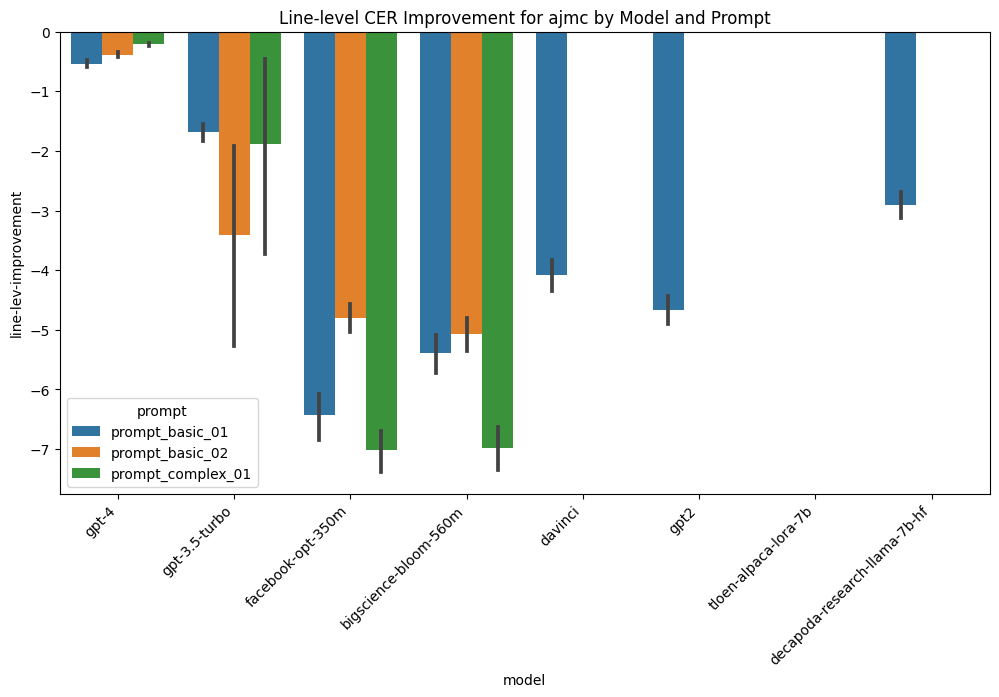

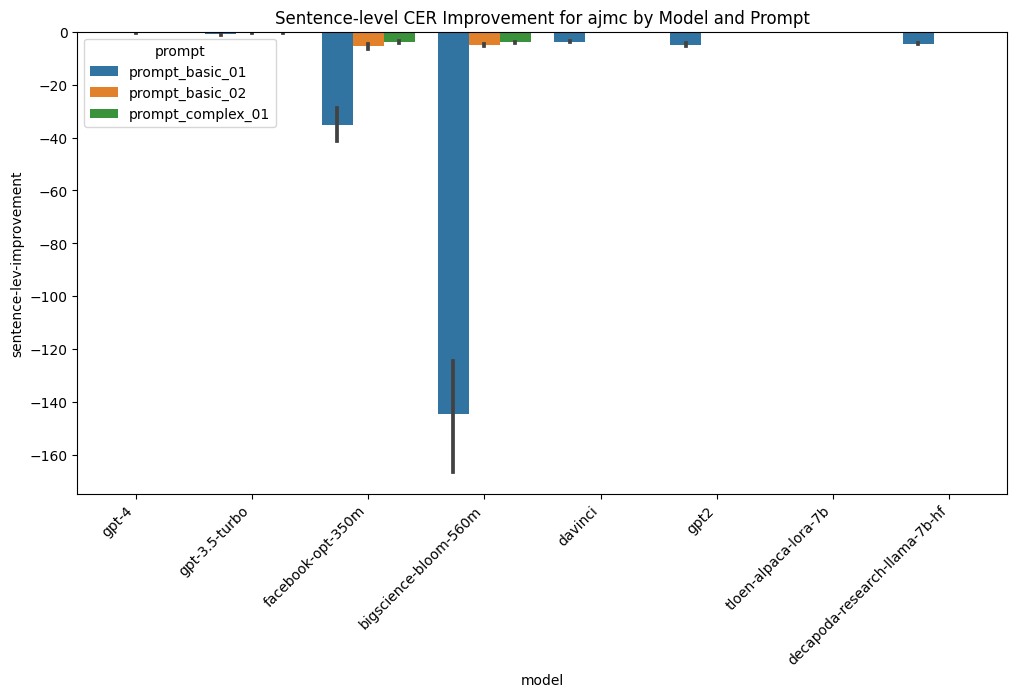

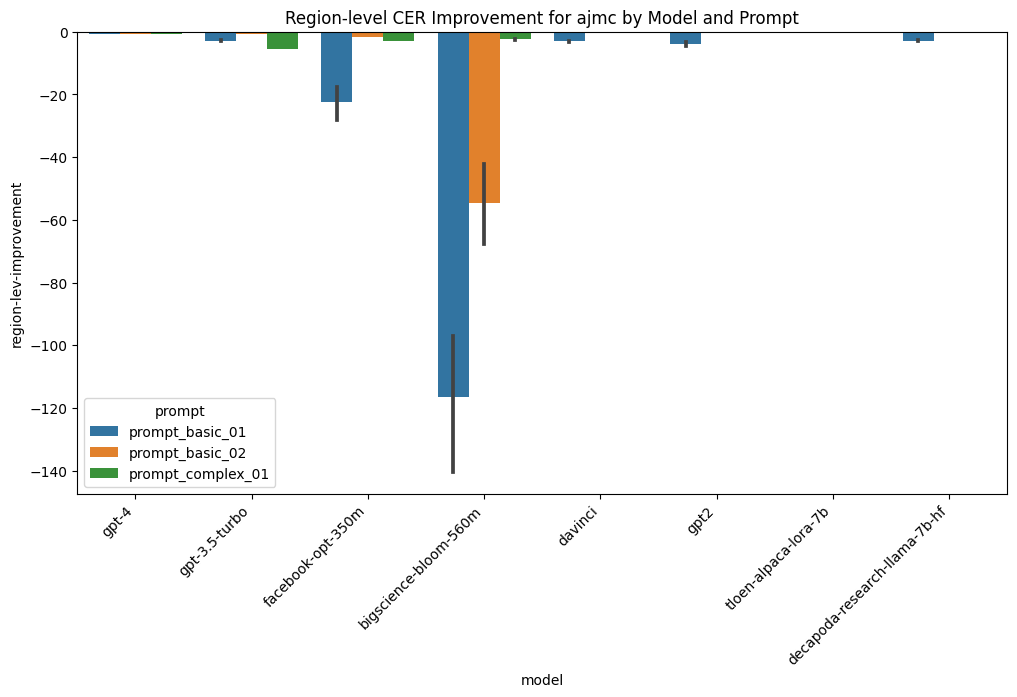

In [226]:
prompt_order = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']  # Replace these with your actual prompt names in the desired order

segment_levels = ['line', 'sentence', 'region']

for level in segment_levels:
    # Create a bar plot for CER improvement
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=dataset, x='model', y=f'{level}-lev-improvement', hue='prompt', hue_order=prompt_order)
    
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.title(f'{level.capitalize()}-level CER Improvement for ajmc by Model and Prompt')
    plt.show()

In [222]:
data.columns

Index(['filename', 'dataset_name', 'article_id', 'ocr.line', 'ocr.sentence',
       'ocr.region', 'groundtruth.line', 'groundtruth.sentence',
       'groundtruth.region', 'prediction.prompt', 'prediction.line',
       'prediction.sentence', 'prediction.region', 'model', 'prompt', 'length',
       'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement', 'line-cer-ocr',
       'line-cer-pred', 'line-wer-ocr', 'line-wer-pred',
       'line-cer-improvement', 'line-wer-improvement', 'line-ocr-noise-group',
       'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement',
       'sentence-cer-ocr', 'sentence-cer-pred', 'sentence-wer-ocr',
       'sentence-wer-pred', 'sentence-cer-improvement',
       'sentence-wer-improvement', 'sentence-ocr-noise-group',
       'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement',
       'region-cer-ocr', 'region-cer-pred', 'region-wer-ocr',
       'region-wer-pred', 'region-cer-improvement', 'region-wer-improvement',
       'region-ocr-n

In [223]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mean_metrics_df = data.groupby(['dataset_name', 'model', 'prompt', 'line-lev-improvement']).mean().reset_index()
print(mean_metrics_df.head())

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_metrics_df, x='dataset_name', y='line-lev-improvement', hue='model')
plt.title('Line-level CER Improvement by Dataset and Model')
plt.show()


TypeError: Could not convert sophoclesplaysa05campgoog to numeric

In [ ]:
for 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for model in data['model'].unique():
    data_per_model = data[data['model'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='dataset_name', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.5, 1.5))
        # Show the plot
        plt.show()



In [ ]:
for model in data['dataset_name'].unique():
    data_per_model = data[data['dataset_name'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='model', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.2, 1.0))
        # Show the plot
        plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for result in results:
    
    dataset_name = result['dataset_name'].unique()[0]
    
    for segment_type in ['line', 'sentence', 'region']:
        
        #grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"]).size().reset_index(name="count")
        
        grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"])[f"{segment_type}-lev-improvement"].mean().reset_index()

        print(grouped_results.head())
        
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        _ = sns.lineplot(x=f"{segment_type}-ocr-noise-group", y=f'{segment_type}-lev-improvement', hue='dataset_name',
                 data=grouped_results, ax=ax, markers=True, linestyle='-', linewidth=2.5)


        # Set plot labels
        ax.set_xlabel(f"{dataset_name} Ground Truth {segment_type.capitalize()}")
        ax.set_ylabel(f"{dataset_name} {segment_type.capitalize()} Improvement")
        ax.set_title(f"{dataset_name} Levenshtein Improvement for {segment_type.capitalize()} OCR Examples")


        # Show the plot
        plt.show()

